# Improve On-Shelf Availability

Reference: https://www.databricks.com/solutions/accelerators/on-shelf-availability

The purpose of this notebook is to access and prepare the data needed for calculating on-shelf availability (OSA). This notebook was developed by Tredence in partnership with Databricks.

Out-of-stock (OOS) scenarios occur when a retailer does not have enough inventory to meet consumer demand. When an insufficient number of product units are made available to customers, not only are immediate sales lost but consumer confidence in the retailer is eroded. 

Out-of-stocks occur for a variety of reasons. Poor forecasting, limited supply, and operational challenges are all common causes. With each, swift action is required to identify and address the source of the problem less they continue to impact sales. The challenge with out of stocks is that by the time it is identified, the lead time for requesting replacement units and making them available on the shelf for the consumer may require the retailer to live with the issue for quite some time. It is therefore important that any analysis of stocking levels consider the time to replenishment associated with a given item and location.

In [49]:
!rm -rf data
#!mkdir data

## OSA-Data
2 datasets are used in the OSA accelerator.

- Inventory Data (osa_raw_data.csv) - Inventory data with information about store and distribution network inventory, store sales, replenishment and store shelf capacity is available in the CSV file mentioned. The file contains data for about 100 Store - SKU combinations and metrics are available at Store - SKU - Day level.

- Vendor Lead Time Information (vendor_leadtime_info.csv) - Lead time (replenishment time) information for products at different stores is available in the CSV file mmentioned. This information is used to understand how long it will take to get additional product. The file contains data for about 100 Store - SKU combinations.

## Data -Preparation

In [2]:
from pyspark import SparkFiles
from pyspark.sql.types import *
import pyspark.sql.functions as f
 
import pandas as pd
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName('On shelf availability').getOrCreate()
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [3]:
url1 ="https://raw.githubusercontent.com/tredenceofficial/OSA-Data/main/osa_raw_data.csv"
spark.sparkContext.addFile(url1)
url2 ="https://raw.githubusercontent.com/tredenceofficial/OSA-Data/main/vendor_leadtime_info.csv"
spark.sparkContext.addFile(url2)

### Access the Inventory Data

In [4]:
# schema for inventory data
inventory_schema = StructType([
  StructField('date',DateType()),
  StructField('store_id',IntegerType()),
  StructField('sku',IntegerType()),
  StructField('product_category',StringType()),
  StructField('total_sales_units',IntegerType()),
  StructField('on_hand_inventory_units',IntegerType()),
  StructField('replenishment_units',IntegerType()),
  StructField('inventory_pipeline',IntegerType()),
  StructField('units_in_transit',IntegerType()),
  StructField('units_in_dc',IntegerType()),
  StructField('units_on_order',IntegerType()),
  StructField('units_under_promotion',IntegerType()),
  StructField('shelf_capacity',IntegerType())
  ])
 
# read inventory data and persist as delta table
(
  spark
   .read
   .csv(
       "file://" + SparkFiles.get("osa_raw_data.csv"),
       header = True,
       schema = inventory_schema,
       dateFormat = 'yyyyMMdd'
       )
   .repartition(spark.sparkContext.defaultParallelism) # repartition to ensure it's written in a manner that supports downstream parallalism
   .write
      .format('parquet')
      .mode('overwrite')
      .save('data/inventory_raw')
   )
display(spark.read.parquet('data/inventory_raw'))

date,store_id,sku,product_category,total_sales_units,on_hand_inventory_units,replenishment_units,inventory_pipeline,units_in_transit,units_in_dc,units_on_order,units_under_promotion,shelf_capacity
2019-02-15,1452,64,Category 01,44,225,0,219,0,0,0,0,100
2020-01-28,1392,64,Category 01,4,15,0,25,0,0,12,0,24
2021-01-08,1936,153,Category 02,0,0,0,0,0,0,0,0,0
2020-11-14,334,52,Category 06,0,0,0,0,0,0,0,0,0
2020-07-17,210,148,Category 03,0,2,0,2,0,0,0,0,4
2020-02-10,1556,8,Category 05,0,4,0,10,0,0,6,0,13
2019-02-16,1857,64,Category 01,16,62,0,62,0,0,0,0,20
2020-05-31,1232,154,Category 01,0,61,0,61,0,0,0,0,0
2019-10-14,1232,154,Category 01,15,84,75,152,0,75,0,0,80
2021-01-15,1741,64,Category 01,0,73,0,106,0,0,36,0,24


### Access the Vendor Data

In [5]:
# schema for vendor data
vendor_schema = StructType([
  StructField('key',IntegerType()),
  StructField('vendor_id',IntegerType()),
  StructField('sub_vendor_id',IntegerType()),
  StructField('store_id',IntegerType()),
  StructField('item_id',IntegerType()),
  StructField('lead_time_in_dc',IntegerType()),
  StructField('lead_time_in_transit',IntegerType()),
  StructField('lead_time_on_order',IntegerType()),
])
 
# read vendor data and persist as delta table
(
  spark
   .read
   .csv(
    "file://" + SparkFiles.get("vendor_leadtime_info.csv"),
     header = True,
     schema = vendor_schema
     )
  .withColumnRenamed('item_id','sku') # rename item_id to sku for consistency with inventory data
   .write
     .format('parquet')
     .mode('overwrite')
     .option('overwriteSchema', 'true')
     .save('data/osa.vendor')
   )
display(spark.read.parquet('data/osa.vendor'))

key,vendor_id,sub_vendor_id,store_id,sku,lead_time_in_dc,lead_time_in_transit,lead_time_on_order
1,1,1001,1763,1,4,3,7
2,1,1001,1763,2,2,1,7
3,1,1002,1843,2,2,1,7
4,1,1001,1763,3,4,3,7
5,2,2016,486,6,2,1,8
6,2,2073,1587,7,3,2,9
7,2,2087,1556,8,4,3,7
8,8,8010,1283,39,3,2,6
9,10,10001,1763,46,2,1,5
10,11,11001,334,52,4,3,8


### Address Missing Records
The inventory data contains records for products in specific stores when an inventory-related transaction occurs. Since not every product moves on every date, there will be days for which there is no data for certain store and product SKU combinations.

Time series analysis techniques used in our framework require a complete set of records for products within a given location. To address the missing entries, we will generate a list of all dates for which we expect records. A cross-join with store-SKU combinations will provide the base set of records for which we expect data.

In the real world, not all products are intended to be sold at each location at all times. In an analysis of non-simulated data, we may require additional information to determine the complete set of dates for a given store-SKU combination for which we should have data:



In [6]:
# calculate start and end of inventory dataset
start_date, end_date = (
  spark.read.parquet('data/inventory_raw')
  .groupBy()
    .agg(
      f.min('date').alias('start_date'),
      f.max('date').alias('end_date')  
        )
  .collect()[0]
  )
 
# generate contiguous set of dates within start and end range
dates = (
  spark
    .range( (end_date - start_date).days + 1 )  # days in range
    .withColumn('id', f.expr('cast(id as integer)')) # range value from long (bigint) to integer
    .withColumn('date', f.lit(start_date) + f.col('id'))  # add range value to start date to generate contiguous date range
    .select('date')
  )
 
# display dates
display(dates.orderBy('date'))

date
2019-01-01
2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10


#### Assemble Complete Set of Stores-SKUs

In [7]:
# extract unique store-sku combinations in inventory records
store_skus = (
  spark.read.parquet('data/inventory_raw')
    .select('store_id','sku','product_category')
    .groupBy('store_id','sku')
      .agg(f.last('product_category').alias('product_category')) # just a hack to get last category assigned to each store-sku combination
  )
 
display(store_skus)

store_id,sku,product_category
63,57,Category 04
98,64,Category 01
164,76,Category 05
171,64,Category 01
178,64,Category 01
206,64,Category 01
209,64,Category 01
210,148,Category 03
232,64,Category 01
249,64,Category 01


We can now cross-join the contiguous dates with each unique store-SKU found in the inventory dataset to create the expected records in our complete dataset. Left outer joining these data to our actual inventory data, we will now have a complete set of records though there will be missing values in many fields which we will need to address in our next step:

In [8]:

# generate one record for each store-sku for each date in range
inventory_with_gaps = (
  dates
    .crossJoin(store_skus)
    .join(
      spark.read.parquet('data/inventory_raw').drop('product_category'), 
      on=['date','store_id','sku'], 
      how='leftouter'
      )
  )

# display inventory records
display(inventory_with_gaps)

date,store_id,sku,product_category,total_sales_units,on_hand_inventory_units,replenishment_units,inventory_pipeline,units_in_transit,units_in_dc,units_on_order,units_under_promotion,shelf_capacity
2019-01-01,63,57,Category 04,null,null,null,null,null,null,null,null,null
2019-01-02,63,57,Category 04,0,8,0,16,0,0,8,0,32
2019-01-03,63,57,Category 04,null,null,null,null,null,null,null,null,null
2019-01-04,63,57,Category 04,0,7,0,14,0,8,0,0,32
2019-01-05,63,57,Category 04,3,5,8,12,8,0,0,0,32
2019-01-06,63,57,Category 04,2,11,0,11,0,0,0,0,32
2019-01-07,63,57,Category 04,null,null,null,null,null,null,null,null,null
2019-01-08,63,57,Category 04,null,null,null,null,null,null,null,null,null
2019-01-09,63,57,Category 04,3,7,0,14,0,0,8,0,32
2019-01-10,63,57,Category 04,2,5,0,13,0,0,8,0,32


### Impute Missing values

In [9]:
# copy dataframe to enable manipulations in loop
inventory_cleansed = inventory_with_gaps
 
# apply forward fill to appropriate columns
for c in ['shelf_capacity', 'on_hand_inventory_units']:
    inventory_cleansed = (
      inventory_cleansed
      .withColumn(
          c, 
          f.expr('LAST({0}, True) OVER(PARTITION BY store_id, sku ORDER BY date)'.format(c)) # get last non-null prior value (aka forward-fill)
           )
        )
  
# apply default value of 0 to appropriate columns
inventory_cleansed = (
  inventory_cleansed
    .fillna(
      0, 
      [ 'total_sales_units',
        'units_under_promotion',
        'units_in_transit',
        'units_in_dc',
        'units_on_order',
        'replenishment_units',
        'inventory_pipeline'
        ]
      )
  )
 
# display data with imputed values
display(inventory_cleansed)   

date,store_id,sku,product_category,total_sales_units,on_hand_inventory_units,replenishment_units,inventory_pipeline,units_in_transit,units_in_dc,units_on_order,units_under_promotion,shelf_capacity
2019-01-01,63,57,Category 04,0,null,0,0,0,0,0,0,null
2019-01-02,63,57,Category 04,0,8,0,16,0,0,8,0,32
2019-01-03,63,57,Category 04,0,8,0,0,0,0,0,0,32
2019-01-04,63,57,Category 04,0,7,0,14,0,8,0,0,32
2019-01-05,63,57,Category 04,3,5,8,12,8,0,0,0,32
2019-01-06,63,57,Category 04,2,11,0,11,0,0,0,0,32
2019-01-07,63,57,Category 04,0,11,0,0,0,0,0,0,32
2019-01-08,63,57,Category 04,0,11,0,0,0,0,0,0,32
2019-01-09,63,57,Category 04,3,7,0,14,0,0,8,0,32
2019-01-10,63,57,Category 04,2,5,0,13,0,0,8,0,32


### Identify Key Inventory Events
With our complete inventory dataset in-hand, we can now identify key inventory-related events within the data. These include the occurrence of promotions intended to drive product sales and replenishment events during which new units are added to inventory:

#### Calculate Inventory Flags

In [10]:
# derive inventory flags
inventory_final = (
  inventory_cleansed
    .withColumn('promotion_flag', f.expr('CASE WHEN units_under_promotion > 0 THEN 1 ELSE 0 END'))
    .withColumn('replenishment_flag', f.expr('CASE WHEN replenishment_units > 0 THEN 1 ELSE 0 END'))
    )
 
display(inventory_final)

date,store_id,sku,product_category,total_sales_units,on_hand_inventory_units,replenishment_units,inventory_pipeline,units_in_transit,units_in_dc,units_on_order,units_under_promotion,shelf_capacity,promotion_flag,replenishment_flag
2019-01-01,63,57,Category 04,0,null,0,0,0,0,0,0,null,0,0
2019-01-02,63,57,Category 04,0,8,0,16,0,0,8,0,32,0,0
2019-01-03,63,57,Category 04,0,8,0,0,0,0,0,0,32,0,0
2019-01-04,63,57,Category 04,0,7,0,14,0,8,0,0,32,0,0
2019-01-05,63,57,Category 04,3,5,8,12,8,0,0,0,32,0,1
2019-01-06,63,57,Category 04,2,11,0,11,0,0,0,0,32,0,0
2019-01-07,63,57,Category 04,0,11,0,0,0,0,0,0,32,0,0
2019-01-08,63,57,Category 04,0,11,0,0,0,0,0,0,32,0,0
2019-01-09,63,57,Category 04,3,7,0,14,0,0,8,0,32,0,0
2019-01-10,63,57,Category 04,2,5,0,13,0,0,8,0,32,0,0


In [11]:
(
  inventory_final
    .repartition(spark.sparkContext.defaultParallelism)
    .write
      .format('parquet')
      .mode('overwrite')
      .save('data/osa.inventory')
   )

## Out of Stock

The purpose of this notebook is to identify inventory-related problems in the data including phantom inventory, safety stock alerts and zero scan alerts. 

In [12]:
import pyspark.sql.functions as f
from pyspark.sql.types import *
 
import pandas as pd

In [13]:
inventory = spark.read.parquet('data/osa.inventory')
vendor = spark.read.parquet('data/osa.vendor')

### Identify Phantom Inventory
Phantom inventory represents product units not accounted for between the inventory and the sales systems. These units may represent items misplaced, stolen, lost or otherwise inaccurately tracked in one system or the other. The identification of these units is essential for ensuring the right quantity, i.e. not too few and not too many, of a given product are purchased for replenishment and may point to needed operational improvements to ensure accurate inventories are maintained moving forward.
![phantom_inventory](./images/phantominventory.png)

Phantom inventory is identified by simply calculating the number of units expected to be on-hand at the end of the day relative to those actually on-hand. Minor differences between the units expected and those actually in inventory may not require immediate attention. A phantom inventory indicator flag is set when the phantom inventory is some multiple of the average daily sales for a given product. Here, we set this multiple to 5-times but some organizations may wish to be more or less sensitive to the detection of problematic levels of phantom inventory:

In [14]:
# phantom inventory calculations
phantom_inventory = (
  inventory
    
    # average daily sales
    .withColumn('daily_sales_units', f.expr('AVG(total_sales_units) OVER(PARTITION BY store_id, sku ORDER BY date)')) 
    
    # on-hand inventory units at the end of previous day
    # for dates with no prior day inventory units, provide alt calculation
    .withColumn('start_on_hand_units', f.expr('''
      COALESCE( 
        LAG(on_hand_inventory_units, 1) OVER(PARTITION BY store_id, sku ORDER BY date), 
        on_hand_inventory_units + total_sales_units - replenishment_units
        )
        ''')) 
    
    # on-hand inventory units at end of day
    .withColumn('end_on_hand_units', f.expr('COALESCE(on_hand_inventory_units, 0)')) 
    
    # calculate phantom inventory as difference in:
    # (previous day's on-hand inventory + current day's replenished units - current day's sales units) and current day's end-of-day inventory 
    .withColumn('phantom_inventory', f.expr('start_on_hand_units + replenishment_units - total_sales_units - end_on_hand_units')) 
    
    # flag only when phantom inventory is at least 5 times average daily sales
    .withColumn('phantom_inventory_ind', f.expr('''
      CASE
        WHEN phantom_inventory <> 0 AND ABS(phantom_inventory) > 5 * daily_sales_units THEN 1 
        ELSE 0 
        END'''))  
  
    .select(
      'date',
      'store_id',
      'sku',
      'daily_sales_units',
      'start_on_hand_units',
      'replenishment_units',
      'total_sales_units',
      'end_on_hand_units',
      'phantom_inventory',
      'phantom_inventory_ind'
      )
    )
 
# display results
display(phantom_inventory)

date,store_id,sku,daily_sales_units,start_on_hand_units,replenishment_units,total_sales_units,end_on_hand_units,phantom_inventory,phantom_inventory_ind
2019-01-01,63,57,0.0,null,0,0,0,null,0
2019-01-02,63,57,0.0,8,0,0,8,0,0
2019-01-03,63,57,0.0,8,0,0,8,0,0
2019-01-04,63,57,0.0,8,0,0,7,1,1
2019-01-05,63,57,0.6,7,8,3,5,7,1
2019-01-06,63,57,0.8333333333333334,5,0,2,11,-8,1
2019-01-07,63,57,0.7142857142857143,11,0,0,11,0,0
2019-01-08,63,57,0.625,11,0,0,11,0,0
2019-01-09,63,57,0.8888888888888888,11,0,3,7,1,0
2019-01-10,63,57,1.0,7,0,2,5,0,0


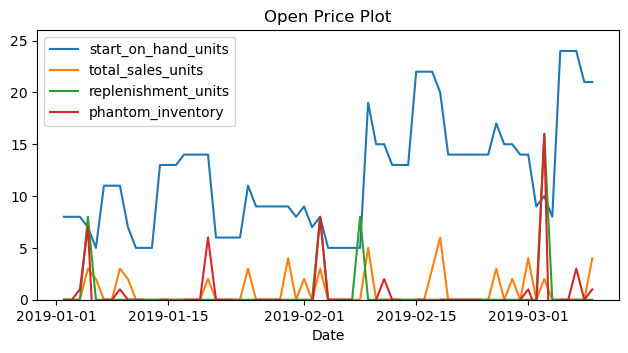

In [20]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [7.50, 3.50]
#plt.rcParams["figure.autolayout"] = True

pdf = phantom_inventory.filter("sku=57 and store_id=63 and date >'2019-01-01' and date <'2019-03-10'").toPandas().set_index('date')
#plt.figure(figsize=(16, 8), dpi=150)
fig, ax = plt.subplots()
pdf[['start_on_hand_units','total_sales_units','replenishment_units','phantom_inventory']].plot(kind='line',ax=ax)
#pdf['replenishment_units'].plot(kind='bar', color='green')
# adding title to the plot
plt.title('Open Price Plot')
plt.ylim(0)
# adding Label to the x-axis
plt.xlabel('Date')
  
# adding legend to the curve
plt.legend()

## Identify Out of Stocks
Out of stocks occur when inventory is not sufficient to meet demand. Most retailers define a safety stock level that serves as the threshold for triggering replenishment orders. When inventory dips below the safety stock level, a replenishment order is generated. The remaining inventory on-hand must then be sufficient to meet demand until the replacement units arrive.

![Out_of_stock](./images/safetystock.png)

There are numerous ways to calculate a safety stock level for a given product. Here, we will consider the store-specific dynamics associated with a product to arrive at two potentially valid safety stock levels. The first of these is the number of units on-hand before past replenishment events. The second of these will consider average daily sales relative to lead times for a product. For a given store-SKU combination, we will take the lower of these two values to be our safety stock level. But before we can calculate these values, we need to estimate the inventory on-hand, something we tackled in our prior phantom inventory calculations:

In [16]:
# combine inventory with phantom inventory and min lead times
inventory_with_pi = (
  inventory.alias('inv')
    .join(phantom_inventory.alias('pi'), on=['store_id','sku','date'])
  
    # limit fields to use moving forward
    .selectExpr(
      'inv.store_id',
      'inv.sku',
      'inv.date',
      'inv.product_category',
      'inv.on_hand_inventory_units',
      'inv.total_sales_units',
      'inv.replenishment_units',
      'inv.replenishment_flag',
      'inv.units_on_order',
      'inv.units_in_transit',
      'inv.units_in_dc',
      'pi.phantom_inventory'
      )
  
  # correct inventory values to enable calculations
  .withColumn('phantom_inventory', f.expr('COALESCE(phantom_inventory, 0)')) 
  .withColumn('on_hand_inventory_units', f.expr('''
              CASE 
                WHEN on_hand_inventory_units < 0 THEN 0 
                ELSE on_hand_inventory_units 
                END''')
             )
   .withColumn('replenishment_units', f.expr('''
              CASE 
                WHEN replenishment_flag = 1 THEN replenishment_units
                ELSE 0 
                END''')
             )
  
  # initialize estimated on-hand inventory field
   .withColumn('estimated_on_hand_inventory', f.lit(0)) 
  )
 
display(inventory_with_pi)

store_id,sku,date,product_category,on_hand_inventory_units,total_sales_units,replenishment_units,replenishment_flag,units_on_order,units_in_transit,units_in_dc,phantom_inventory,estimated_on_hand_inventory
63,57,2019-01-01,Category 04,null,0,0,0,0,0,0,0,0
63,57,2019-01-02,Category 04,8,0,0,0,8,0,0,0,0
63,57,2019-01-03,Category 04,8,0,0,0,0,0,0,0,0
63,57,2019-01-04,Category 04,7,0,0,0,0,0,8,1,0
63,57,2019-01-05,Category 04,5,3,8,1,0,8,0,7,0
63,57,2019-01-06,Category 04,11,2,0,0,0,0,0,-8,0
63,57,2019-01-07,Category 04,11,0,0,0,0,0,0,0,0
63,57,2019-01-08,Category 04,11,0,0,0,0,0,0,0,0
63,57,2019-01-09,Category 04,7,3,0,0,8,0,0,1,0
63,57,2019-01-10,Category 04,5,2,0,0,8,0,0,0,0


### Estimate On-Hand Inventory

In [21]:
# iterate over inventory to calculate current inventory levels
def get_estimated_inventory(inventory_pd: pd.DataFrame) -> pd.DataFrame:
  
    inventory_pd.sort_values('date', inplace=True)
  
    # iterate over records in inventory data
    for i in range(1,len(inventory_pd)):
    
        # get component values
        previous_inv = inventory_pd.estimated_on_hand_inventory.iloc[i-1]
        if previous_inv < 0: previous_inv = 0

        replenishment_units = inventory_pd.replenishment_units.iloc[i]
        total_sales_units = inventory_pd.total_sales_units.iloc[i]
        phantom_inventory_units = inventory_pd.phantom_inventory.iloc[i]
        on_hand_inventory_units = inventory_pd.on_hand_inventory_units.iloc[i]

        # calculate estimated on-hand inventory
        estimated_on_hand_inventory = previous_inv + replenishment_units - total_sales_units - phantom_inventory_units
        if estimated_on_hand_inventory < 0: estimated_on_hand_inventory = 0
        if estimated_on_hand_inventory > on_hand_inventory_units: estimated_on_hand_inventory = on_hand_inventory_units

        inventory_pd.estimated_on_hand_inventory.iloc[i] = estimated_on_hand_inventory

    return inventory_pd
 
 
# calculate estimated on-hand inventory
inventory_on_hand = (
  inventory_with_pi
  .groupby('store_id', 'sku')
    .applyInPandas( get_estimated_inventory, schema=inventory_with_pi.schema )
  )
 
display(inventory_on_hand)

store_id,sku,date,product_category,on_hand_inventory_units,total_sales_units,replenishment_units,replenishment_flag,units_on_order,units_in_transit,units_in_dc,phantom_inventory,estimated_on_hand_inventory
63,57,2019-01-01,Category 04,null,0,0,0,0,0,0,0,0
63,57,2019-01-02,Category 04,8,0,0,0,8,0,0,0,0
63,57,2019-01-03,Category 04,8,0,0,0,0,0,0,0,0
63,57,2019-01-04,Category 04,7,0,0,0,0,0,8,1,0
63,57,2019-01-05,Category 04,5,3,8,1,0,8,0,7,0
63,57,2019-01-06,Category 04,11,2,0,0,0,0,0,-8,6
63,57,2019-01-07,Category 04,11,0,0,0,0,0,0,0,6
63,57,2019-01-08,Category 04,11,0,0,0,0,0,0,0,6
63,57,2019-01-09,Category 04,7,3,0,0,8,0,0,1,2
63,57,2019-01-10,Category 04,5,2,0,0,8,0,0,0,0


Using this data, we can now calculate the average amount on-hand prior to a replenishment event as well as the average number of units sold for each store-SKU. For both metrics, we'll limit the calculation to the 90 days prior to the current inventory record. This will allow for changes in stocking practices and sales velocity over the dataset:

### Calculate Average On-Hand and Average Daily Sales Metrics

In [25]:
inventory_with_metrics = (
  inventory_on_hand
    
    # AVERAGE ON-HAND UNITS PRIOR TO REPLENISHMENT
    # ------------------------------------------------------------------------------------
    # getting prior day's on-hand inventory only for the days with replenishment
    .withColumn('prior_inventory', f.expr('LAG(estimated_on_hand_inventory, 1) OVER(PARTITION BY store_id, sku ORDER BY date)'))
    .withColumn('prior_inventory', f.expr('COALESCE(prior_inventory,0)'))
    .withColumn('prior_inventory', f.expr('CASE WHEN replenishment_flag=1 THEN prior_inventory ELSE 0 END'))
  
    # calculating rolling average of prior day's on-hand inventory for days with replenishment (over last 90 days)
    .withColumn('rolling_stock_onhand', f.expr('''
      SUM(prior_inventory) OVER(PARTITION BY store_id, sku ORDER BY date ROWS BETWEEN 90 PRECEDING AND CURRENT ROW) /
      (SUM(replenishment_flag) OVER(PARTITION BY store_id, sku ORDER BY date ROWS BETWEEN 90 PRECEDING AND CURRENT ROW) + 1)
      '''
      ))
    .withColumn('rolling_min_expected_stock', f.expr('CASE WHEN replenishment_flag != 1 THEN 0 ELSE rolling_stock_onhand END'))
    .withColumn('rolling_min_expected_stock', f.expr('COALESCE(rolling_min_expected_stock,0)'))
    
    # fixing the inventory values for all dates through forward fill
    .withColumn('min_expected_stock', f.expr('NULLIF(rolling_min_expected_stock,0)'))
    .withColumn('min_expected_stock', f.expr('LAST(min_expected_stock, True) OVER(PARTITION BY store_id, sku ORDER BY date)'))
    .withColumn('min_expected_stock', f.expr('COALESCE(min_expected_stock, 0)'))
    # ------------------------------------------------------------------------------------
  
    # AVERAGE DAILY SALES
    # ------------------------------------------------------------------------------------
    # getting daily sales velocity
    .withColumn('daily_sales_units', f.expr('AVG(total_sales_units) OVER(PARTITION BY store_id, sku ORDER BY date ROWS BETWEEN 90 PRECEDING AND CURRENT ROW)'))
    .withColumn('daily_sales_units', f.expr('LAST(daily_sales_units, True) OVER(PARTITION BY store_id, sku ORDER BY date)'))
    .withColumn('daily_sales_units', f.expr('COALESCE(daily_sales_units, 0)'))
    # ------------------------------------------------------------------------------------
  )
 
display(inventory_with_metrics)

store_id,sku,date,product_category,on_hand_inventory_units,total_sales_units,replenishment_units,replenishment_flag,units_on_order,units_in_transit,units_in_dc,phantom_inventory,estimated_on_hand_inventory,prior_inventory,rolling_stock_onhand,rolling_min_expected_stock,min_expected_stock,daily_sales_units
63,57,2019-01-01,Category 04,null,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
63,57,2019-01-02,Category 04,8,0,0,0,8,0,0,0,0,0,0.0,0.0,0.0,0.0
63,57,2019-01-03,Category 04,8,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
63,57,2019-01-04,Category 04,7,0,0,0,0,0,8,1,0,0,0.0,0.0,0.0,0.0
63,57,2019-01-05,Category 04,5,3,8,1,0,8,0,7,0,0,0.0,0.0,0.0,0.6
63,57,2019-01-06,Category 04,11,2,0,0,0,0,0,-8,6,0,0.0,0.0,0.0,0.8333333333333334
63,57,2019-01-07,Category 04,11,0,0,0,0,0,0,0,6,0,0.0,0.0,0.0,0.7142857142857143
63,57,2019-01-08,Category 04,11,0,0,0,0,0,0,0,6,0,0.0,0.0,0.0,0.625
63,57,2019-01-09,Category 04,7,3,0,0,8,0,0,1,2,0,0.0,0.0,0.0,0.8888888888888888
63,57,2019-01-10,Category 04,5,2,0,0,8,0,0,0,0,0,0.0,0.0,0.0,1.0


To derive safety stock levels using average daily sales, we need to know something about the lead times for the replenishment of particular SKUs within a given store location. We can derive this as follows:

### Calculate Shortest Lead Time for Each Store-SKU

In [26]:
# calculate shortest lead time for each store-sku combination
lead_time = (
  vendor
    .withColumn('min_lead_time', f.expr('LEAST(lead_time_in_dc, lead_time_in_transit, lead_time_on_order)'))
    .select('store_id', 'sku', 'min_lead_time', 'lead_time_in_dc', 'lead_time_in_transit', 'lead_time_on_order')
    )
 
display(lead_time)

store_id,sku,min_lead_time,lead_time_in_dc,lead_time_in_transit,lead_time_on_order
1763,1,3,4,3,7
1763,2,1,2,1,7
1843,2,1,2,1,7
1763,3,3,4,3,7
486,6,1,2,1,8
1587,7,2,3,2,9
1556,8,3,4,3,7
1283,39,2,3,2,6
1763,46,1,2,1,5
334,52,3,4,3,8


### Determine Safety Stock

In [27]:
inventory_safety_stock = (
  inventory_with_metrics
    .join(lead_time, on=['store_id','sku'], how='leftouter')
  
    # safety stock for sales velocity is avg daily sales units * min_lead_time
    .withColumn('ss_sales_velocity', f.expr('daily_sales_units * min_lead_time'))
  
    # use the lower of the min_expected_stock at replinishment or sales_velocity-derived stock requirement as safety stock
    .withColumn('safety_stock', f.expr('CASE WHEN min_expected_stock < ss_sales_velocity THEN min_expected_stock ELSE ss_sales_velocity END'))
    .withColumn('safety_stock', f.expr('CASE WHEN replenishment_flag != 1 THEN 0 ELSE safety_stock END'))
    .withColumn('safety_stock', f.expr('COALESCE(safety_stock,0)'))
    .withColumn('safety_stock', f.expr('CASE WHEN safety_stock=0 THEN min_expected_stock ELSE safety_stock END'))
  
    .select(
      'date',
      'store_id',
      'sku',
      'product_category',
      'total_sales_units', 
      'on_hand_inventory_units',
      'replenishment_units', 
      'replenishment_flag',
      'phantom_inventory',
      'estimated_on_hand_inventory',  
      'prior_inventory',
      'rolling_min_expected_stock', 
      'min_expected_stock',
      'daily_sales_units', 
      'safety_stock', 
      'units_on_order',
      'units_in_transit',
      'units_in_dc',
      'lead_time_in_transit',
      'lead_time_in_dc',
      'lead_time_on_order'
      )
  )
 
display(inventory_safety_stock)

date,store_id,sku,product_category,total_sales_units,on_hand_inventory_units,replenishment_units,replenishment_flag,phantom_inventory,estimated_on_hand_inventory,prior_inventory,rolling_min_expected_stock,min_expected_stock,daily_sales_units,safety_stock,units_on_order,units_in_transit,units_in_dc,lead_time_in_transit,lead_time_in_dc,lead_time_on_order
2019-01-01,63,57,Category 04,0,null,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,3,4,10
2019-01-02,63,57,Category 04,0,8,0,0,0,0,0,0.0,0.0,0.0,0.0,8,0,0,3,4,10
2019-01-03,63,57,Category 04,0,8,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,3,4,10
2019-01-04,63,57,Category 04,0,7,0,0,1,0,0,0.0,0.0,0.0,0.0,0,0,8,3,4,10
2019-01-05,63,57,Category 04,3,5,8,1,7,0,0,0.0,0.0,0.6,0.0,0,8,0,3,4,10
2019-01-06,63,57,Category 04,2,11,0,0,-8,6,0,0.0,0.0,0.8333333333333334,0.0,0,0,0,3,4,10
2019-01-07,63,57,Category 04,0,11,0,0,0,6,0,0.0,0.0,0.7142857142857143,0.0,0,0,0,3,4,10
2019-01-08,63,57,Category 04,0,11,0,0,0,6,0,0.0,0.0,0.625,0.0,0,0,0,3,4,10
2019-01-09,63,57,Category 04,3,7,0,0,1,2,0,0.0,0.0,0.8888888888888888,0.0,8,0,0,3,4,10
2019-01-10,63,57,Category 04,2,5,0,0,0,0,0,0.0,0.0,1.0,0.0,8,0,0,3,4,10


With a safety stock level defined for each store-SKU, we can now identify dates where:

- The on-hand inventory is less than the safety stock level (on_hand_less_than_safety_stock)
- The requested replinishment units are not sufficient to meet safety stock requirements (insufficient_inventory_pipeline_units)
- The inventory pipeline is one day away from not being able to fulfill stocking requirements (insufficient_lead_time)
- Each of these conditions represents an inventory management problem which requires addressing. The first two of these conditions may be calculated as follows:

#### Identify Insufficient Inventory On-Hand & In-Pipeline Events

In [29]:
inventory_safety_stock_alert = (
  inventory_safety_stock
  
  # alert 1 - estimated on-hand inventory is less than safety stock
  .withColumn('on_hand_less_than_safety_stock', f.expr('CASE WHEN estimated_on_hand_inventory <= safety_stock THEN 1 ELSE 0 END'))
  
  # alert 2 - inventory in pipeline is not sufficient to reach the safety stock levels
  .withColumn('insufficient_inventory_pipeline_units', f.expr('''
    CASE
      WHEN  (on_hand_less_than_safety_stock = 1) AND 
            (units_on_order + units_in_transit + units_in_dc != 0) AND
            ((units_on_order + units_in_transit + units_in_dc) < (safety_stock - estimated_on_hand_inventory))
         THEN 1
      ELSE 0
      END'''))
  )
 
display(inventory_safety_stock_alert)

date,store_id,sku,product_category,total_sales_units,on_hand_inventory_units,replenishment_units,replenishment_flag,phantom_inventory,estimated_on_hand_inventory,prior_inventory,rolling_min_expected_stock,min_expected_stock,daily_sales_units,safety_stock,units_on_order,units_in_transit,units_in_dc,lead_time_in_transit,lead_time_in_dc,lead_time_on_order,on_hand_less_than_safety_stock,insufficient_inventory_pipeline_units
2019-01-01,63,57,Category 04,0,null,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,3,4,10,1,0
2019-01-02,63,57,Category 04,0,8,0,0,0,0,0,0.0,0.0,0.0,0.0,8,0,0,3,4,10,1,0
2019-01-03,63,57,Category 04,0,8,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,3,4,10,1,0
2019-01-04,63,57,Category 04,0,7,0,0,1,0,0,0.0,0.0,0.0,0.0,0,0,8,3,4,10,1,0
2019-01-05,63,57,Category 04,3,5,8,1,7,0,0,0.0,0.0,0.6,0.0,0,8,0,3,4,10,1,0
2019-01-06,63,57,Category 04,2,11,0,0,-8,6,0,0.0,0.0,0.8333333333333334,0.0,0,0,0,3,4,10,0,0
2019-01-07,63,57,Category 04,0,11,0,0,0,6,0,0.0,0.0,0.7142857142857143,0.0,0,0,0,3,4,10,0,0
2019-01-08,63,57,Category 04,0,11,0,0,0,6,0,0.0,0.0,0.625,0.0,0,0,0,3,4,10,0,0
2019-01-09,63,57,Category 04,3,7,0,0,1,2,0,0.0,0.0,0.8888888888888888,0.0,8,0,0,3,4,10,0,0
2019-01-10,63,57,Category 04,2,5,0,0,0,0,0,0.0,0.0,1.0,0.0,8,0,0,3,4,10,1,0


#### Identify Insufficient Lead Time Events

In [30]:
# calculate lead times associated with inventory records
inventory_safety_stock_with_lead_times = (
  
  inventory_safety_stock_alert
  
    # lead time values at store-sku level for various stages 
    .withColumn('lead_time_in_transit', f.expr('COALESCE(lead_time_in_transit,0)'))
    .withColumn('lead_time_on_order', f.expr('COALESCE(lead_time_on_order,0)'))
    .withColumn('lead_time_in_dc', f.expr('COALESCE(lead_time_in_dc,0)'))
 
    # considering lead time only if estimated on-hand inventory and inventory in pipeline meet the safety stock levels
    .withColumn('lead_time', f.expr('''
       CASE
         WHEN on_hand_less_than_safety_stock = 1 AND
              (units_on_order + units_in_transit + units_in_dc != 0) AND
              ((units_on_order + units_in_transit + units_in_dc) >= (safety_stock - estimated_on_hand_inventory)) 
           THEN GREATEST(
                 COALESCE(lead_time_in_transit,0),
                 COALESCE(lead_time_on_order,0),
                 COALESCE(lead_time_in_dc,0)
                 )+1
         ELSE null 
         END'''))
  )
 
# identify lead time problems
lead_time_alerts = (
  
  inventory_safety_stock_with_lead_times.alias('a')
  
    # self join to get the previous lead time (most recent one) for the inventory pipeline
    .join(
      (inventory_safety_stock_with_lead_times
          .filter(
            f.expr('lead_time Is Not Null') # considering only non-null records
             ).alias('b')
        ), 
      on=f.expr('a.store_id=b.store_id AND a.sku=b.sku AND a.date > b.date'), 
      how='leftouter'
      )
    .groupBy('a.store_id','a.sku','a.date')
      .agg(
          f.max('a.lead_time').alias('lead_time'),
          f.max('b.date').alias('lead_date'), # day on which the lead time was assigned to the inventory pipeline
          f.max('b.lead_time').alias('prev_lead_time') # lead time assigned to the inventory pipeline
        )
  
    # flag is raised if difference in current date and lead date (from above) is greater than the lead time assigned (prev_lead_time)
    .withColumn('date_diff', f.expr('DATEDIFF(date, lead_date)'))
    .withColumn('insufficient_lead_time', f.expr('''
      CASE
        WHEN lead_time IS NULL AND (prev_lead_time - date_diff) <= 0 THEN 1
        ELSE 0
        END
      '''))
    .select(
      'date',
      'store_id',
      'sku',
      'insufficient_lead_time'
      )
  .join(
    inventory_safety_stock_alert,
    on=['store_id','sku','date']
    )
  )
 
 
display(lead_time_alerts)

store_id,sku,date,insufficient_lead_time,product_category,total_sales_units,on_hand_inventory_units,replenishment_units,replenishment_flag,phantom_inventory,estimated_on_hand_inventory,prior_inventory,rolling_min_expected_stock,min_expected_stock,daily_sales_units,safety_stock,units_on_order,units_in_transit,units_in_dc,lead_time_in_transit,lead_time_in_dc,lead_time_on_order,on_hand_less_than_safety_stock,insufficient_inventory_pipeline_units
63,57,2019-05-11,1,Category 04,0,1,0,0,0,0,0,0.0,5.25,0.8681318681318682,5.25,0,0,0,3,4,10,1,0
63,57,2019-09-12,0,Category 04,0,23,0,0,0,22,0,0.0,15.125,0.7032967032967034,15.125,0,0,0,3,4,10,0,0
63,57,2020-02-24,1,Category 04,3,23,0,0,-1,23,0,0.0,15.75,0.9560439560439561,15.75,0,0,0,3,4,10,0,0
63,57,2020-10-25,1,Category 04,2,35,0,0,-37,35,0,0.0,8.333333333333334,0.4945054945054945,8.333333333333334,24,0,0,3,4,10,0,0
98,64,2019-04-20,1,Category 01,8,21,0,0,-18,17,0,0.0,7.666666666666667,1.4945054945054945,7.666666666666667,0,0,0,2,3,9,0,0
98,64,2020-07-16,1,Category 01,0,0,0,0,0,0,0,0.0,10.375,0.0,10.375,0,0,0,2,3,9,1,0
98,64,2020-09-23,1,Category 01,0,0,0,0,0,0,0,0.0,10.375,0.0,10.375,0,0,0,2,3,9,1,0
98,64,2020-12-05,0,Category 01,0,13,0,0,0,13,0,0.0,18.5,0.9120879120879121,18.5,0,0,0,2,3,9,1,0
164,76,2019-04-06,1,Category 05,0,7,0,0,0,6,0,0.0,0.7142857142857143,0.23076923076923078,0.7142857142857143,0,0,0,3,4,10,0,0
164,76,2019-05-19,1,Category 05,0,10,0,0,0,10,0,0.0,1.5714285714285714,0.3076923076923077,1.5714285714285714,0,0,0,3,4,10,0,0


In [31]:
consolidated_oos_alerts = (
  lead_time_alerts
    .withColumn('alert_indicator', f.expr('''
      CASE
        WHEN on_hand_less_than_safety_stock = 1 AND insufficient_inventory_pipeline_units = 1 THEN 1 
        WHEN on_hand_less_than_safety_stock = 1 AND insufficient_inventory_pipeline_units != 1 AND insufficient_lead_time = 1 THEN 1
        ELSE 0
        END'''))
    .select(
      'date',
      'store_id',
      'sku',
      'product_category',
      'total_sales_units',
      'daily_sales_units',
      'alert_indicator'
      )
  )
 
display(consolidated_oos_alerts)

date,store_id,sku,product_category,total_sales_units,daily_sales_units,alert_indicator
2019-05-11,63,57,Category 04,0,0.8681318681318682,1
2019-09-12,63,57,Category 04,0,0.7032967032967034,0
2020-02-24,63,57,Category 04,3,0.9560439560439561,0
2020-10-25,63,57,Category 04,2,0.4945054945054945,0
2019-04-20,98,64,Category 01,8,1.4945054945054945,0
2020-07-16,98,64,Category 01,0,0.0,1
2020-09-23,98,64,Category 01,0,0.0,1
2020-12-05,98,64,Category 01,0,0.9120879120879121,0
2019-04-06,164,76,Category 05,0,0.23076923076923078,0
2019-05-19,164,76,Category 05,0,0.3076923076923077,0


### Identify Zero Sales Issues
Not every product sells each day in each store location. But when a product goes unsold for a long period of time, it might be wise for someone to verify it is still in inventory.

![zero_scan](./images/zeroscan.png)
The challenge is that what constitutes a long period of time. Some products move relatively quickly while many products move only occasionally. For a product that sales hundreds of units daily, we might suspect an inventory problem if we suddenly see no sales on a given day. For a product that moves only a few units a month, a few days or even a few weeks with no units sold may be nothing to be concerned with.

With that in mind, we need to examine the number of days with zero units sold for each store-SKU combination relative to the total days a product is available for sale in order to understand the probability a product will experience a zero-sales day:

In [32]:
# calculate ratio of total days of zero sales and total days on shelf across observed period
zero_sales_totals = ( 
  inventory
    .withColumn('total_zero_sales_days', f.expr('CASE WHEN total_sales_units == 0 THEN 1 ELSE 0 END'))
    .withColumn('total_days', f.expr('1'))
    .groupBy(['store_id', 'sku'])
      .agg(
        f.sum('total_days').alias('total_days'),
        f.sum('total_zero_sales_days').alias('total_zero_sales_days')
        )
    .withColumn('zero_sales_day_probability', f.expr('total_zero_sales_days / total_days'))
    )
 
display(zero_sales_totals)

store_id,sku,total_days,total_zero_sales_days,zero_sales_day_probability
1540,155,854,654,0.765807962529274
1283,39,854,794,0.9297423887587822
397,64,854,584,0.6838407494145199
1822,111,854,794,0.9297423887587822
339,64,854,550,0.6440281030444965
1634,110,854,572,0.6697892271662763
1843,2,854,548,0.6416861826697893
334,52,854,794,0.9297423887587822
171,64,854,656,0.7681498829039812
373,64,854,569,0.6662763466042154


#### Calculate Consecutive Zero Sales Days

In [33]:
zero_sales_days = (
  
  inventory 
  
    # flag the occurance of first zero sales day in a series
    .withColumn('sales_change_flag', f.expr('''
        CASE 
          WHEN total_sales_units=0 AND LAG(total_sales_units,1) OVER(PARTITION BY store_id, sku ORDER BY date) != 0 THEN 1 
          ELSE 0 
          END''')) 
  
    # count number of zero sales day series to date (associates records with a given series)
    .withColumn('zero_sales_flag_rank', f.expr('SUM(sales_change_flag) OVER(PARTITION BY store_id, sku ORDER BY date)')) 
  
    # flag all zero sales days
    .withColumn('sales_change_flag_inv', f.expr('CASE WHEN total_sales_units = 0 THEN 1 ELSE 0 END')) 
  
    # count consecutive zero sales days (counter resets with a non-zero sales instance)
    .withColumn('total_days_wo_sales', f.expr('SUM(sales_change_flag_inv) OVER(PARTITION BY store_id, sku, zero_sales_flag_rank ORDER BY date)'))
    .withColumn('total_days_wo_sales', f.expr('CASE WHEN total_sales_units != 0 THEN 0 ELSE total_days_wo_sales END'))
    
    .select(
      'date',
      'store_id',
      'sku',
      'total_sales_units',
      'zero_sales_flag_rank',
      'sales_change_flag_inv',
      'total_days_wo_sales'
      )
  )
 
display(zero_sales_days.orderBy('store_id','sku','date'))

date,store_id,sku,total_sales_units,zero_sales_flag_rank,sales_change_flag_inv,total_days_wo_sales
2019-01-01,63,57,0,0,1,1
2019-01-02,63,57,0,0,1,2
2019-01-03,63,57,0,0,1,3
2019-01-04,63,57,0,0,1,4
2019-01-05,63,57,3,0,0,0
2019-01-06,63,57,2,0,0,0
2019-01-07,63,57,0,1,1,1
2019-01-08,63,57,0,1,1,2
2019-01-09,63,57,3,1,0,0
2019-01-10,63,57,2,1,0,0


We know the probability that a product will experience a zero-sales date in a given store location. Using this value, we can calculate the probability of a product would realistically experience consecutive zero-sales days using a simple function. When that probability reaches or exceeds a particular threshold (set here at 5% to reflect a fairly low risk tolerance), we might take that as a signal to send someone to inspect the inventory:

In [34]:
zero_sales_inventory = (
  zero_sales_days
    .join(zero_sales_totals.alias('prob'), on=['store_id', 'sku'], how = 'leftouter')
    .withColumn('zero_sales_probability', f.expr('pow(zero_sales_day_probability, total_days_wo_sales)'))
    .withColumn('no_sales_flag', f.expr('CASE WHEN zero_sales_probability < 0.05 THEN 1 ELSE 0 END'))
  )
 
display(zero_sales_inventory.orderBy('store_id','sku','date'))

store_id,sku,date,total_sales_units,zero_sales_flag_rank,sales_change_flag_inv,total_days_wo_sales,total_days,total_zero_sales_days,zero_sales_day_probability,zero_sales_probability,no_sales_flag
63,57,2019-01-01,0,0,1,1,854,654,0.765807962529274,0.765807962529274,0
63,57,2019-01-02,0,0,1,2,854,654,0.765807962529274,0.5864618354732378,0
63,57,2019-01-03,0,0,1,3,854,654,0.765807962529274,0.4491171433249386,0
63,57,2019-01-04,0,0,1,4,854,654,0.765807962529274,0.34393748446663913,0
63,57,2019-01-05,3,0,0,0,854,654,0.765807962529274,1.0,0
63,57,2019-01-06,2,0,0,0,854,654,0.765807962529274,1.0,0
63,57,2019-01-07,0,1,1,1,854,654,0.765807962529274,0.765807962529274,0
63,57,2019-01-08,0,1,1,2,854,654,0.765807962529274,0.5864618354732378,0
63,57,2019-01-09,3,1,0,0,854,654,0.765807962529274,1.0,0
63,57,2019-01-10,2,1,0,0,854,654,0.765807962529274,1.0,0


### Identify Alert Conditions
We now have identified several conditions that require attention. We first identified problematic phantom inventory conditions and then identified inventory below safety stock levels. Finally, we identified days with zero sales events likely to be a result of an inventory issue. In this last step, we'll consolidate all this information to build a set with which we can more clearly identify inventory dates requiring attention from analysts:

In [35]:
all_alerts = (
  consolidated_oos_alerts.alias('oos') # OOS alert
    .join(phantom_inventory.alias('pi'), on=['store_id','sku','date'], how='leftouter') # pahntom inventory indicator
    .join(zero_sales_inventory, on=['store_id','sku','date'], how='leftouter') # zero sales alert
    .selectExpr(
      'date',
      'store_id',
      'sku',
      'product_category',
      'oos.total_sales_units',
      'oos.alert_indicator as oos_alert',
      'oos.daily_sales_units',
      'no_sales_flag as zero_sales_flag',
      'phantom_inventory',
      'phantom_inventory_ind'
      )
  )
 
display(all_alerts)

date,store_id,sku,product_category,total_sales_units,oos_alert,daily_sales_units,zero_sales_flag,phantom_inventory,phantom_inventory_ind
2019-05-11,63,57,Category 04,0,1,0.8681318681318682,0,0,0
2019-09-12,63,57,Category 04,0,0,0.7032967032967034,0,0,0
2020-02-24,63,57,Category 04,3,0,0.9560439560439561,0,-1,0
2020-10-25,63,57,Category 04,2,0,0.4945054945054945,0,-37,1
2019-04-20,98,64,Category 01,8,0,1.4945054945054945,0,-18,1
2020-07-16,98,64,Category 01,0,1,0.0,1,0,0
2020-09-23,98,64,Category 01,0,1,0.0,1,0,0
2020-12-05,98,64,Category 01,0,0,0.9120879120879121,0,0,0
2019-04-06,164,76,Category 05,0,0,0.23076923076923078,0,0,0
2019-05-19,164,76,Category 05,0,0,0.3076923076923077,0,0,0


In [39]:
(
  all_alerts
    .repartition(spark.sparkContext.defaultParallelism)
    .write
      .format('parquet')
      .mode('overwrite')
      .option('overwriteSchema', 'true')
      .save('data/osa.inventory_flagged')
   )

## On-Shelf Availability

The purpose of this notebook is to forecast sales over an historical period and then use those forecasted values to identify potential on-shelf availability concerns. 

We identified inventory problems through the detection of excessive phantom inventory, stocking levels below safety stock thresholds and unexpected numbers of consecutive days with zero sales. We might label these out-of-stock issues in that they identify scenarios where product is simply not available to be sold.

In this notebook, we want to add a fourth inventory scenario, one where insufficient stock may not fully prevent sales but where they may cause us to miss our sales expectations. Misplacement of product in the store or displays which give the customer a sense a product is not available are both examples of the kinds of issues we might describe as on-shelf availability problems.

With this fourth scenario, we will generate a forecast for sales and identify historical sales values that were depressed relative to what was expected. These periods of lower than expected sales may then be investigated as periods potentially experiencing OSA challenges. To generate this forecast, we must first access our historical sales data:

In [40]:
from pyspark.sql.types import *
import pyspark.sql.functions as f
 
import pandas as pd
import numpy as np
import math
from datetime import timedelta
    
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [41]:
inventory_flagged = spark.read.parquet('data/osa.inventory_flagged')

### Generate Forecast
Unlike most forecasting exercises, our goal is not to predict future values but instead to generate expected values for the historical period. To do this, we may make use of a variety of forecasting techniques. Most enterprises already have established preferences for sales forecasting so instead of wading into the conversation about which techniques are best in different scenarios, we will make use of a simple exponential smoothing as a placeholder technique so that we might focus on the analysis against the forecasted values in later steps.

In [43]:
alpha_value = 0.8 # smoothing factor
 
# function to generate a forecast for a store-sku
def get_forecast(keys, inventory_pd: pd.DataFrame) -> pd.DataFrame:
  
    # identify store and sku
    store_id = keys[0]
    sku = keys[1]
  
    # identify date range for predictions
    history_start = inventory_pd['date'].min()
    history_end = inventory_pd['date'].max()
  
  # organize data for model training
    timeseries = (
      inventory_pd
        .set_index('date', drop=True, append=False) # move date to index
        .sort_index() # sort on date-index
      )['total_sales_units'] # just need this one field
  
    # fit model to timeseries
    model = SimpleExpSmoothing(timeseries, initialization_method='heuristic').fit(smoothing_level=alpha_value)

    # predict sales across historical period
    predictions = model.predict(start=history_start, end=history_end)

    # convert timeseries to dataframe for return
    predictions_pd = predictions.to_frame(name='predicted_sales_units').reset_index() # convert to df
    predictions_pd.rename(columns={'index':'date'}, inplace=True) # rename 'index' column to 'date'
    predictions_pd['store_id'] = store_id # assign store id
    predictions_pd['sku'] = sku # assign sku

    return predictions_pd[['date', 'store_id', 'sku', 'predicted_sales_units']]
 
# structure of forecast function output
forecast_schema = StructType([
  StructField('date', DateType()), 
  StructField('store_id', IntegerType()), 
  StructField('sku', IntegerType()), 
  StructField('predicted_sales_units', FloatType())
  ])

In [44]:
# get forecasted values for each store-sku combination
forecast = (
  inventory_flagged
    .groupby(['store_id','sku'])
      .applyInPandas(
        get_forecast, 
        schema=forecast_schema
        )
    .withColumn('predicted_sales_units', f.expr('ROUND(predicted_sales_units,0)')) # round values to nearest integer
    )
 
display(forecast)

date,store_id,sku,predicted_sales_units
2019-01-01,63,57,0.0
2019-01-02,63,57,0.0
2019-01-03,63,57,0.0
2019-01-04,63,57,0.0
2019-01-05,63,57,0.0
2019-01-06,63,57,2.0
2019-01-07,63,57,2.0
2019-01-08,63,57,0.0
2019-01-09,63,57,0.0
2019-01-10,63,57,2.0


In [45]:
(
  forecast
    .write
    .format('parquet')
    .mode('overwrite')
    .save('data/osa.inventory_forecast')
  )

### Identify Off Sales Issues
With forecasts in-hand, we will now look for historical periods where there is not only a lower than expected number of sales (relative to our forecasts) but where this difference grows over a number of days. Identifying these periods may help us identify on-shelf availability (OSA) concerns we may need to address.



![offsales](./images/offsales.jpg)
Of course, not every missed sales target is an OSA event. To focus our attention, we will look for periods of sustained misses where the miss is sizeable relative to our expectations. In the code that follows, we require 4-days of increasing misses with an average daily miss of 20% or more of the expected sales. Some organizations may wish to increase or decrease these threshold requirements depending on the nature of their business:

In [48]:
inventory_forecast = spark.read.parquet('data/osa.inventory_forecast')
 
osa_flag_output = (
  
  inventory_flagged.alias('inv')
    .join(inventory_forecast.alias('for'), on=['store_id','sku','date'], how='leftouter')
    .selectExpr(
      'inv.*',
      'for.predicted_sales_units'
      )
             
    # calculating difference between forecasted and actual sales units
    .withColumn('units_difference', f.expr('predicted_sales_units - total_sales_units'))
    .withColumn('units_difference', f.expr('COALESCE(units_difference, 0)'))
 
    # check whether deviation has been increasing over past 4 days
    .withColumn('osa_alert_inc_deviation', f.expr('''
      CASE 
        WHEN units_difference > LAG(units_difference, 1) OVER(PARTITION BY store_id, sku ORDER BY date) AND 
             LAG(units_difference, 1) OVER(PARTITION BY store_id, sku ORDER BY date) > LAG(units_difference, 2) OVER(PARTITION BY store_id, sku ORDER BY date) AND 
             LAG(units_difference, 2) OVER(PARTITION BY store_id, sku ORDER BY date) > LAG(units_difference, 3) OVER(PARTITION BY store_id, sku ORDER BY date)
             THEN 1
        ELSE 0 
        END'''))
    .withColumn('osa_alert_inc_deviation', f.expr('COALESCE(osa_alert_inc_deviation, 0)'))
 
    # rolling 4 day average of sales units
    .withColumn('sales_4day_avg', f.expr('AVG(total_sales_units) OVER(PARTITION BY store_id, sku ORDER BY date ROWS BETWEEN 3 PRECEDING AND CURRENT ROW)'))
 
    # rolling 4 day average of forecasted units
    .withColumn('predictions_4day_avg', f.expr('AVG(predicted_sales_units) OVER(PARTITION BY store_id, sku ORDER BY date ROWS BETWEEN 3 PRECEDING AND CURRENT ROW)'))
 
    # calculating deviation in rolling average of sales and forecast units
    .withColumn('deviation', f.expr('(predictions_4day_avg - sales_4day_avg) / (predictions_4day_avg+1)'))
    .withColumn('deviation', f.expr('COALESCE(deviation, 0)'))
 
    # Considering 20% deviation as the threshold for OSA flag
    .withColumn('off_sales_alert', f.expr('''
      CASE 
        WHEN deviation > 0.20  AND osa_alert_inc_deviation = 1 THEN 1
        ELSE 0
        END'''))
 
    .select('date', 
            'store_id', 
            'sku', 
            'predicted_sales_units', 
            'off_sales_alert',
            'oos_alert', 
            'zero_sales_flag', 
            'phantom_inventory', 
            'phantom_inventory_ind')
    )
 
display(osa_flag_output)

date,store_id,sku,predicted_sales_units,off_sales_alert,oos_alert,zero_sales_flag,phantom_inventory,phantom_inventory_ind
2019-01-01,63,57,0.0,0,0,0,null,0
2019-01-02,63,57,0.0,0,0,0,0,0
2019-01-03,63,57,0.0,0,0,0,0,0
2019-01-04,63,57,0.0,0,0,0,1,1
2019-01-05,63,57,0.0,0,0,0,7,1
2019-01-06,63,57,2.0,0,0,0,-8,1
2019-01-07,63,57,2.0,0,0,0,0,0
2019-01-08,63,57,0.0,0,0,0,0,0
2019-01-09,63,57,0.0,0,0,0,1,0
2019-01-10,63,57,2.0,0,0,0,0,0
